<a href="https://colab.research.google.com/github/arishaprasain/Customer-Credit-Card-Churning/blob/main/pneumoniadetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/AI HACKATON'

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
    zip_ref.extractall()


In [6]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score 

In [7]:
train_path = r'/content/chest_xray/chest_xray/train'
test_path = r'/content/chest_xray/chest_xray/test'
val_path = r'/content/chest_xray/chest_xray/val'

NORMAL
(1380, 1558)


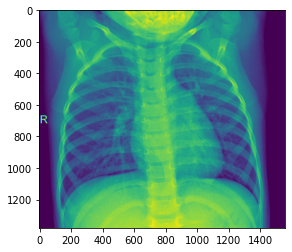

(1279, 1746)


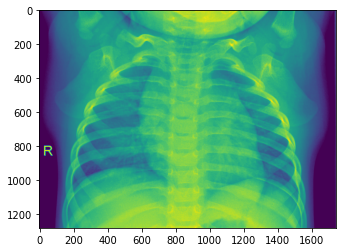

PNEUMONIA
(680, 1016)


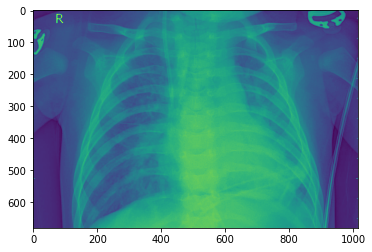

(528, 1040)


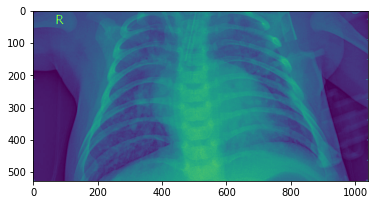

In [8]:
for folder in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, folder)):
        target_path = os.path.join(train_path, folder)
        print(folder)

        for i in range(0,2):
            img_path = os.listdir(target_path)[i]
            img_path = os.path.join(target_path, img_path)
            img = mpimg.imread(img_path)
            print(img.shape)
            imgplot = plt.imshow(img)
            plt.show()


We have used data augmentation in this dataset to adress the class imbalance as this technique naturaly increases the number of minority samples while training by rotation, flipping, and zooming to the images of the minority clas

In [9]:
def img_to_array(path,size):
  data = []
  for folder in os.listdir(train_path):
      if os.path.isdir(os.path.join(train_path, folder)):
          target_path = os.path.join(train_path, folder)
          print(folder)

          for img in os.listdir(target_path):
              if os.path.splitext(img)[1] in ('.jpg', '.jpeg', '.png'):
                  img_path = os.path.join(target_path, img)             
                  array = cv2.imread(img_path)
                  array = cv2.resize(array, size)
                  array = np.array(array)
                  
                  data.append(array)
          print(array.shape)

  return data

In [10]:
size = (150,150)
train = img_to_array(train_path, size)
test = img_to_array(test_path, size)


NORMAL
(150, 150, 3)
PNEUMONIA
(150, 150, 3)
NORMAL
(150, 150, 3)
PNEUMONIA
(150, 150, 3)


In [11]:
val = img_to_array(val_path, size)

NORMAL
(150, 150, 3)
PNEUMONIA
(150, 150, 3)


In [12]:
train[0].shape

(150, 150, 3)

In [19]:
len(train)

5216

In [13]:
train = np.array(train)
test = np.array(test)
val = np.array(val)

In [14]:
x_train = train/255.0

x_val = val/255.0


In [15]:
x_test = test/255.0

In [23]:
x_train[0]

array([[[0.11372549, 0.11372549, 0.11372549],
        [0.14901961, 0.14901961, 0.14901961],
        [0.21176471, 0.21176471, 0.21176471],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.09019608, 0.09019608, 0.09019608],
        [0.14509804, 0.14509804, 0.14509804],
        [0.19607843, 0.19607843, 0.19607843],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.07843137, 0.07843137, 0.07843137],
        [0.12941176, 0.12941176, 0.12941176],
        [0.18823529, 0.18823529, 0.18823529],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

**Defining target variables**

In [16]:
#load images from a directory and convert them into batches of tensors by applying some preprocessing like rescaling, resizing and etc.
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 fill_mode = 'nearest',
                                 horizontal_flip = True)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 32,
                                          class_mode = class_mode)
    return classes

In [17]:
train_data = data_class(train_path,size, 'binary')
test_data = data_class(test_path,size, 'binary')
val_data = data_class(val_path,size, 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
y_train = train_data.classes
y_test = test_data.classes
y_val = val_data.classes

In [19]:
len(train_data)
train_data[0]

(array([[[[0.20330696, 0.20330696, 0.20330696],
          [0.20330696, 0.20330696, 0.20330696],
          [0.20330696, 0.20330696, 0.20330696],
          ...,
          [0.51188165, 0.51188165, 0.51188165],
          [0.51188165, 0.51188165, 0.51188165],
          [0.51188165, 0.51188165, 0.51188165]],
 
         [[0.17980646, 0.17980646, 0.17980646],
          [0.17980646, 0.17980646, 0.17980646],
          [0.17980646, 0.17980646, 0.17980646],
          ...,
          [0.489534  , 0.489534  , 0.489534  ],
          [0.489534  , 0.489534  , 0.489534  ],
          [0.489534  , 0.489534  , 0.489534  ]],
 
         [[0.148181  , 0.148181  , 0.148181  ],
          [0.148181  , 0.148181  , 0.148181  ],
          [0.148181  , 0.148181  , 0.148181  ],
          ...,
          [0.46387944, 0.46387944, 0.46387944],
          [0.46387944, 0.46387944, 0.46387944],
          [0.46387944, 0.46387944, 0.46387944]],
 
         ...,
 
         [[0.00754746, 0.00754746, 0.00754746],
          [0.00754

In [20]:
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [21]:
type(y_train)

numpy.ndarray

In [22]:
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [23]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

**VGG 19 MODEL**

In [24]:
vgg = VGG19(input_shape = (150,150,3), weights = 'imagenet', include_top = False)

In [25]:
#preserving the weights of pretrained model
for layer in vgg.layers:
  layer.trainable = False

In [26]:
x = Flatten()(vgg.output)
prediction = Dense(1, activation = 'sigmoid')(x)

In [27]:
#creating the model object
model = Model(inputs = vgg.input,
              outputs = prediction
              )

In [28]:
model.summary()

model.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

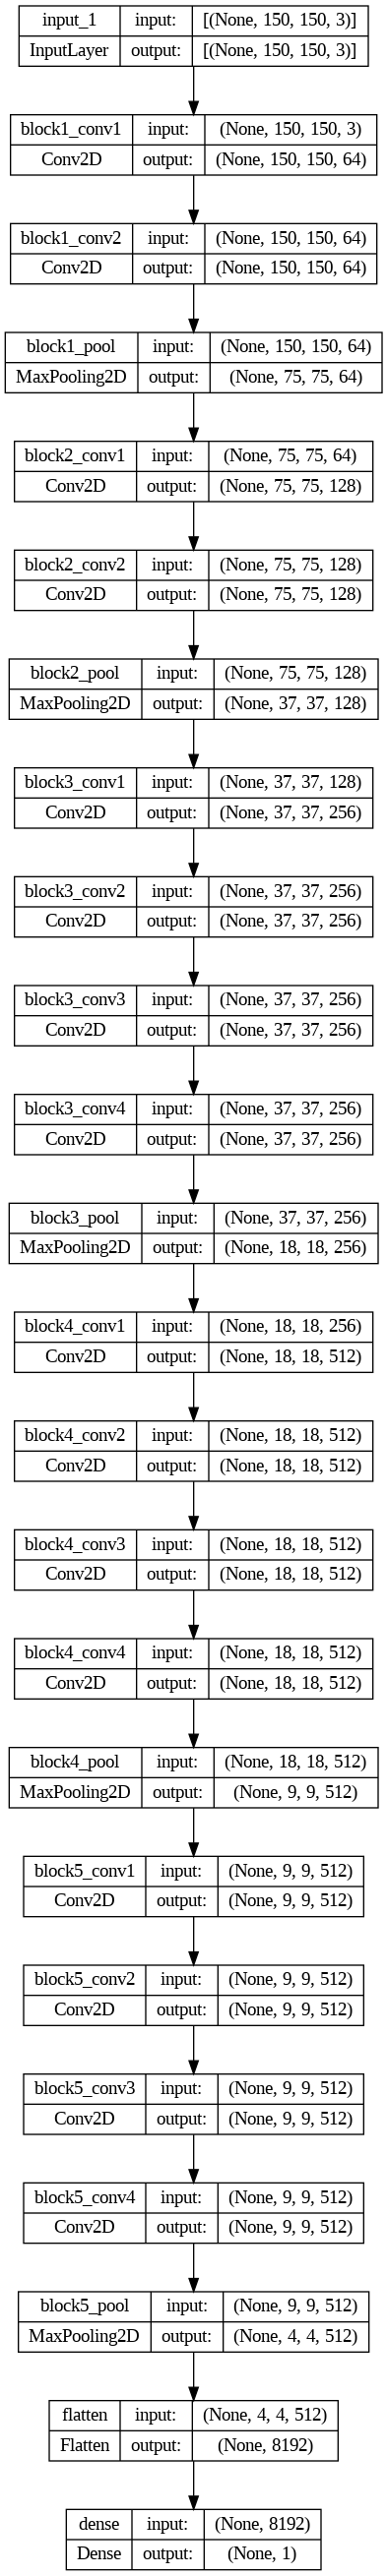

In [29]:
plot_model(model=model, show_shapes=True)

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)

In [31]:
history = model.fit_generator(train_data, 
                    steps_per_epoch = len(train_data),
                    validation_data = val_data, 
                    validation_steps = len(val_data),
                    epochs = 1, 
                    callbacks=[early_stop], 
                    
                    shuffle=True)

<ipython-input-31-baf650458a04>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


163/163 [==============================] - 100s 535ms/step - loss: 0.2534 - accuracy: 0.8946 - val_loss: 0.4263 - val_accuracy: 0.8125


In [32]:
model.save('pneumonia_detection.h5')

In [29]:
from keras.models import load_model

In [39]:
from imageio import imread

In [34]:
from keras.applications.vgg16 import preprocess_input

In [35]:

model=load_model('pneumonia_detection.h5')

In [49]:
test_loss, test_acc = model.evaluate_generator(test_data, steps = len(test_data))

print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


<ipython-input-49-0d97d26bdb8a>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_data, steps = len(test_data))


Test loss: 0.34118351340293884
Test accuracy: 0.8509615659713745


In [41]:
img = imread('/content/IM-0001-0001.jpeg')

In [43]:

x = np.array(img)

In [44]:
x = np.expand_dims(x, axis = 0)

In [47]:
#img_data = preprocess_input(x)
#img_data = img_data.resize()

(1, 1317, 1857)